### Setting up FourRooms

In [1]:

import sys,os
sys.path.append('../')
import matplotlib.pyplot as plt

from deep_rl.component.fourrooms import *

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mila/p/penmet

In [2]:
from gym_minigrid.wrappers import *
env = gym.make('MiniGrid-Empty-8x8-v0')
env = RGBImgObsWrapper(env) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field
obs = env.reset() # This now produces an RGB tensor only
# env = TransposeImage(env)

In [3]:
obs.shape

(64, 64, 3)

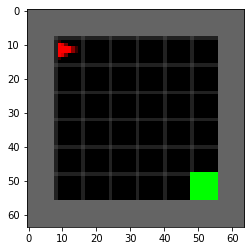

In [4]:
plt.imshow(obs)

### Run DQN on 4 rooms

In [1]:
import sys,os
sys.path.append('../')

from deep_rl import *
import matplotlib.pyplot as plt
import torch
# from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
select_device(0)

In [3]:
class NatureConvBody(nn.Module):
    def __init__(self, in_channels=4):
        super(NatureConvBody, self).__init__()
        self.feature_dim = 512
        self.conv1 = layer_init(nn.Conv2d(in_channels, 32, kernel_size=3, stride=2))
        self.conv2 = layer_init(nn.Conv2d(32, 64, kernel_size=3, stride=2))
        self.fc4 = layer_init(nn.Linear(9 * 9 * 64, self.feature_dim))

    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = F.relu(self.conv2(y))
        # import pdb; pdb.set_trace()
        y = y.view(y.size(0), -1)
        y = F.relu(self.fc4(y))
        return y

In [5]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.action_dim = 3

#     config.optimizer_fn = lambda params: torch.optim.RMSprop(
#         params, lr=0.00025, alpha=0.95, eps=0.001, centered=True)
    config.optimizer_fn = lambda params: torch.optim.RMSprop(
        params, lr=0.001, centered=True)
#     config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(43,)))
    config.network_fn = lambda: VanillaNet(config.action_dim, NatureConvBody(in_channels=4))
#     print(config.action_dim)
    config.replay_fn = lambda: Replay(memory_size=int(1e6), batch_size=32)
#     config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)
    config.batch_size = 32
    config.state_normalizer = ImageNormalizer()
    config.reward_normalizer = SignNormalizer()

    config.random_action_prob = LinearSchedule(1.0, 0.01, 2e5)
    config.discount = 0.99
    config.target_network_update_freq = 2000
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e10)
    config.max_steps = 1
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    for i in tqdm(range(int(config.max_steps))):
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % 5000:
#             agent.eval_episodes()
            print(agent.total_steps)
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [6]:
game = 'MiniGrid-Empty-5x5-v0'
# game = 'BoxingNoFrameskip-v0'
# game = 'CartPole-v0'
agent = dqn_feature(game=game)

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


2020-09-21 09:30:59,473 - wandb.jupyter - ERROR: Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2020-09-21 09:30:59,636 - wandb.run_manager - INFO: system metrics and metadata threads started
2020-09-21 09:30:59,642 - wandb.run_manager - INFO: checking resume status, waiting at most 10 seconds
2020-09-21 09:30:59,755 - wandb.run_manager - INFO: resuming run from id: UnVuOnYxOjJmNG9zNjdkOnNhbXBsZS1wcm9qZWN0OnBzdXJ5YQ==
2020-09-21 09:30:59,833 - wandb.run_manager - INFO: upserting run before process can begin, waiting at most 10 seconds
2020-09-21 09:30:59,978 - wandb.run_manager - INFO: saving pip packages
2020-09-21 09:30:59,984 - wandb.run_manager - INFO: initializing streaming files api
2020-09-21 09:30:59,987 - wandb.run_manager - INFO: unblocking file change observer, beginning sync with W&B servers
100%|██████████| 1

0


2020-09-21 09:31:00,472 - wandb.run_manager - INFO: file/dir created: /home/mila/p/penmetss/DeepRLv2/notebooks/wandb/run-20200921_093059-2f4os67d/wandb-summary.json
2020-09-21 09:31:00,480 - wandb.run_manager - INFO: file/dir created: /home/mila/p/penmetss/DeepRLv2/notebooks/wandb/run-20200921_093059-2f4os67d/wandb-events.jsonl
2020-09-21 09:31:00,487 - wandb.run_manager - INFO: file/dir created: /home/mila/p/penmetss/DeepRLv2/notebooks/wandb/run-20200921_093059-2f4os67d/wandb-metadata.json
2020-09-21 09:31:00,493 - wandb.run_manager - INFO: file/dir created: /home/mila/p/penmetss/DeepRLv2/notebooks/wandb/run-20200921_093059-2f4os67d/wandb-history.jsonl
2020-09-21 09:31:00,499 - wandb.run_manager - INFO: file/dir created: /home/mila/p/penmetss/DeepRLv2/notebooks/wandb/run-20200921_093059-2f4os67d/requirements.txt
2020-09-21 09:31:00,641 - wandb.run_manager - INFO: stopping streaming files and file change observer
2020-09-21 09:31:01,475 - wandb.run_manager - INFO: file/dir modified: /h

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(np.array(agent.returns)[:,0], np.array(agent.returns)[:,1], '.-')
plt.xlabel('timesteps'), plt.ylabel('returns')
plt.title('DQN performance on ' + game), plt.show()

In [5]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
# from tqdm.notebook import trange, tqdm
import random
import numpy as np

select_device(0)

class torch_reshape(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, 64, 9, 9)

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class SRNetImage(nn.Module):
    def __init__(self, output_dim, hidden_units_sr=(512*4,), hidden_units_psi2q=(), gate=F.relu, config=1):
        """
        This network has two heads: SR head (SR) and reconstruction head (rec).
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
        super(SRNetImage, self).__init__()
        self.feature_dim = 512
        self.output_dim = output_dim
        self.gate = gate

        self.encoder = nn.Sequential(
            layer_init(nn.Conv2d(3, 32, kernel_size=3, stride=2)),  # b, 16, 10, 10
            nn.ReLU(True),
            layer_init(nn.Conv2d(32, 64, kernel_size=3, stride=2)), 
            nn.ReLU(True),
            Flatten(),
            nn.Linear(9 * 9 * 64, self.feature_dim)
        )

        self.decoder = nn.Sequential(
            layer_init(nn.Linear(self.feature_dim, 9 * 9 * 64)),
            torch_reshape(),
            layer_init(nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2)),  # b, 16, 5, 5
            nn.ReLU(True),
            layer_init(nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, output_padding=1)),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.Tanh()
        )

        # layers for SR
        dims_sr = (self.feature_dim,) + hidden_units_sr + (self.feature_dim * output_dim,)
        self.layers_sr = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims_sr[:-1], dims_sr[1:])])

        # SR final head layer
        if(config == 0):
            self.psi2q = Psi2QNet(output_dim, self.feature_dim)
        if(config == 1):
            self.psi2q = Psi2QNetFC(output_dim, self.feature_dim, hidden_units=hidden_units_psi2q)

        self.to(Config.DEVICE)

    def forward(self, x):

        # Finding the latent layer
        phi = self.encoder(tensor(x)) # shape: b x state_dim

        # Reconstruction
        state_est = self.decoder(phi)

        # Estimating the SR from the latent layer
        psi = phi
        for layer in self.layers_sr[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers_sr[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.feature_dim) # shape: b x action_dim x state_dim
        q_est = self.psi2q(psi)

        return phi, psi, state_est, q_est

In [7]:
a = SRNetImage(output_dim=4)
a.layers_sr.parameters()

<generator object Module.parameters at 0x7f6683b09048>

In [8]:
class avDSRAgent_v2(BaseAgent):
    def __init__(self, config, agents, style='DQN'):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_rec_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.choice = config.choice
        self.actor = avDSRActor_v2(config, agents, style, self.choice)

        self.network = config.network_fn()
        self.network.share_memory()
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.optimizer_phi = config.optimizer_fn(list(self.network.encoder.parameters()) + \
                                                 list(self.network.decoder.parameters()))
        self.optimizer_psi = config.optimizer_fn(self.network.layers_sr.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            with torch.no_grad():
                _, psi_next, _, _ = self.network(next_states)

            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            phi, psi, state_rec, _ = self.network(states)
            psi_next.add_(phi) # TODO: double chec this

            # Computing estimates
            actions = tensor(actions).long()
            psi = psi[self.batch_indices, actions, :]
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()

            # Estimating reconstuction loss
            loss_rec = (state_rec - tensor(states)).pow(2).mul(0.5).mean()
            loss = loss_psi + config.c(self.total_steps) * loss_rec
            
            total_loss = loss.mean()
            self.loss_vec.append(total_loss.item())
            self.loss_psi_vec.append(loss_psi.item())
            self.loss_rec_vec.append(loss_rec.item())
            
            # Alternative way to estiamte the loss
            # Step 1: Update weights of phi and phi_rec
            self.optimizer.zero_grad()
            loss_rec.backward(retain_graph=True)
            with config.lock:
                self.optimizer_phi.step() 
            # Step 2: Update weights of psi
            self.optimizer_psi.zero_grad()
            loss_psi.backward()
            with config.lock:
                self.optimizer_psi.step()
                
            
            
            
#             self.optimizer.zero_grad()
#             loss.backward()

#             nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

#             with config.lock:
#                 self.optimizer.step()

In [9]:
def avdsr_feature_v2(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)
    config.action_dim=3

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = LinearSchedule(1, 1, 3e4)

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=2e-4)
    config.network_fn = lambda: SRNetImage(config.action_dim, config=1) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(2e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = avDSRAgent_v2(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [10]:
class torch_reshape(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, 64, 9, 9)

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class Pick():
    def __init__(self):
        self.network = 0
        
class avDSRActor_v2(BaseActor):
    def __init__(self, config, agents, style='DQN', choice=1):
        """
        style -> depicts the network config of the agent used for exploration.
        choice -> tells how we choose which agent to use for exploration
            0 - at every timestep, we randomly pick and agent and take an eps greedy action
            1 - we choose a new DQN every switch_period
        """
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.style = style
        self.choice = choice

        # Parameters to decide which agents should learn
        self.batch_steps = 0
        self.switch_period = 10
        self.agent_id = 0

        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        
        # Choosing which agent for taking actions

        if(len(self.agents) == 0):
            pick = Pick()
            pick.network = lambda a: torch.zeros(self.config.action_dim,1)
        elif(self.choice == 0):                
            pick = random.choice(self.agents)
        elif(self.choice == 1):
            self.batch_steps += 1
            if(self.batch_steps % self.switch_period == 0): 
                # CHECK: multiprocessing might be screwing something up
                self.agent_id = np.random.randint(len(self.agents))
            pick = self.agents[self.agent_id]
        else:
            raise NameError('Invalid choice config')

        # Find qvalues of the picked agent for the present state
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick.network(config.state_normalizer(self._state))
            elif(self.style == 'DQN'):
                q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        # Take action based on this estimated q value
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        if(len(self.agents) == 0):
            pick2 = Pick()
            pick2.network = lambda a : torch.zeros(self.config.action_dim,1)
        elif(self.choice == 0):
            pick2 = random.choice(self.agents)
        elif(self.choice == 1):
            pick2 = pick

        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick2.network(config.state_normalizer(next_state))
            elif(self.style=='DQN'):
                q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry

In [11]:
avdsr = avdsr_feature_v2(game='MiniGrid-Empty-5x5-v0', agents=[], choice=0)

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
2020-09-20 07:31:49,097 - root - INFO: steps 0, 299593142.86 steps/s
2020-09-20 07:31:52,477 - root - INFO: steps 1000, 296.00 steps/s
2020-09-20 07:31:55,875 - root - INFO: steps 2000, 294.48 steps/s
2020-09-20 07:31:59,328 - root - INFO: steps 3000, 289.87 steps/s
2020-09-20 07:32:02,776 - root - INFO: steps 4000, 290.19 steps/s
2020-09-20 07:32:06,068 - root - INFO: steps 5000, 303.86 steps/s
2020-09-20 07:32:09,311 - root - INFO: steps 6000, 308.55 steps/s
2020-09-20 07:32:12,845 - root - INFO: steps 7000, 283.15 steps/s
2020-09-20 07:32:16,166 - root - INFO: steps 8000, 301.24 steps/s
2020-09-20 07:32:19,586 - root - INFO: steps 9000, 292.58 steps/s
2020-09-20 07:32:22,995 - root - INFO: steps 10000, 293.47 steps/s
2020-09-20 07:32:26,539 - r

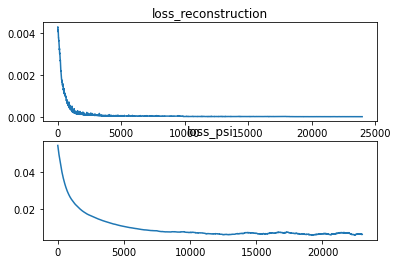

In [12]:
plt.subplot(211), plt.plot(convolve(avdsr.loss_rec_vec,10)[1000:]), plt.title('loss_reconstruction')
plt.subplot(212), plt.plot(convolve(avdsr.loss_psi_vec,1000)[1000:]), plt.title('loss_psi')
plt.show()

In [16]:
torch.save(avdsr.network, '../storage/40-avdsr-trained-minigrid.weights')

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SRNetImage. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type torch_reshape. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [13]:
import gym
from gym.spaces.box import Box
class TransposeImage(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(TransposeImage, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[1], obs_shape[0]],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)/255

In [14]:
from gym_minigrid.wrappers import *
env = gym.make('MiniGrid-Empty-5x5-v0')
env = RGBImgObsWrapper(env) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field
env = TransposeImage(env) # Get rid of the 'mission' field
obs = env.reset() # This now produces an RGB tensor only
obs, _, _, _ = env.step(2)
obs, _, _, _ = env.step(2)
obs, _, _, _ = env.step(1)
obs, _, _, _ = env.step(2)
obs, _, _, _ = env.step(1)

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(3, 40, 40) (3, 40, 40)


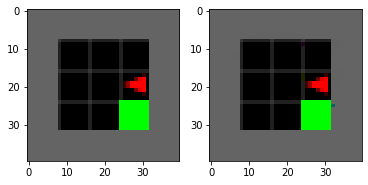

In [15]:
_, _, recons, _ = avdsr.network(tensor(obs).unsqueeze(0))
re_np = recons.squeeze(0).detach().cpu().numpy()
print(obs.shape, re_np.shape)
plt.subplot(121), plt.imshow(obs.transpose(1,2,0))
plt.subplot(122), plt.imshow(re_np.transpose(1,2,0)); plt.show()

## Next: using the learnt representations to learn DQN

In [2]:
weights = torch.load('../storage/40-avdsr-trained-minigrid.weights').state_dict()

def dsr_feature_init(weights,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNetImage(7, config=1, hidden_units_psi2q=())
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent_v2(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(weights is not None):
        print(agent.network.load_state_dict(weights, strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            print(agent.total_steps)
#             agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [ ]:
GAME = 'MiniGrid-Empty-5x5-v0'
agent = dsr_feature_init(game=GAME, freeze=2, weights=weights)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])
0
5000
10000
15000
20000
25000
30000
35000
40000
45000


In [7]:
weights.keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.5.weight', 'encoder.5.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'layers_sr.0.weight', 'layers_sr.0.bias', 'layers_sr.1.weight', 'layers_sr.1.bias'])

In [6]:
weights.pop('psi2q.layers.0.weight')
weights.pop('psi2q.layers.0.bias')

tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

### Comparing performance:

Likely to improve if DSR is trained for longer with a smaller learning rate

- DQN: 169 -> 676 -> 4
- avDSR: 169 -> 676 -> 4

In [11]:
print(avdsr.network.state_dict().keys())
statedict = avdsr.network.state_dict()
del statedict['psi2q.layers.0.weight']
del statedict['psi2q.layers.0.bias']
print(statedict.keys())

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.5.weight', 'encoder.5.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'layers_sr.0.weight', 'layers_sr.0.bias', 'layers_sr.1.weight', 'layers_sr.1.bias', 'psi2q.layers.0.weight', 'psi2q.layers.0.bias'])
odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.5.weight', 'encoder.5.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'layers_sr.0.weight', 'layers_sr.0.bias', 'layers_sr.1.weight', 'layers_sr.1.bias'])


In [12]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 5e-4)
    config.network_fn = lambda: SRNetImage(config.action_dim, hidden_units_psi2q=(2048,1024,64), config=1) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 7e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = DSRAgent_v2(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
#         print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
        print(agent.network.load_state_dict(statedict, strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [13]:
def runNAgents(function, runs, store=True, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in range(runs): 
        agent = function(game='MiniGrid-Empty-5x5-v0', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [ ]:
r_c0 = runNAgents(dsr_feature_init, runs=1, freeze=2, ref=avdsr)
# r_c1 = runNAgents(dsr_feature_init, runs=3, freeze=2, ref=avdsr)
# r_dqn_base_16 = runNAgents(dqn_feature, runs=3)
# r_dqn_base_676 = runNAgents(dqn_feature, runs=1)

IncompatibleKeys(missing_keys=['psi2q.layers.0.weight', 'psi2q.layers.0.bias', 'psi2q.layers.1.weight', 'psi2q.layers.1.bias', 'psi2q.layers.2.weight', 'psi2q.layers.2.bias', 'psi2q.layers.3.weight', 'psi2q.layers.3.bias'], unexpected_keys=[])


2020-08-22 19:44:28,062 - root - INFO: steps 0, episodic_return_test 0.00(0.00)
2020-08-22 19:44:51,861 - root - INFO: steps 5000, episodic_return_test 0.00(0.00)
2020-08-22 19:45:19,108 - root - INFO: steps 10000, episodic_return_test 0.00(0.00)
2020-08-22 19:45:42,929 - root - INFO: steps 15000, episodic_return_test 0.00(0.00)
2020-08-22 19:46:06,481 - root - INFO: steps 20000, episodic_return_test 0.00(0.00)
2020-08-22 19:46:30,057 - root - INFO: steps 25000, episodic_return_test 0.00(0.00)
2020-08-22 19:46:53,468 - root - INFO: steps 30000, episodic_return_test 0.00(0.00)
2020-08-22 19:47:17,065 - root - INFO: steps 35000, episodic_return_test 0.00(0.00)
2020-08-22 19:47:40,740 - root - INFO: steps 40000, episodic_return_test 0.00(0.00)
2020-08-22 19:48:04,310 - root - INFO: steps 45000, episodic_return_test 0.00(0.00)
2020-08-22 19:48:27,679 - root - INFO: steps 50000, episodic_return_test 0.00(0.00)
2020-08-22 19:48:51,281 - root - INFO: steps 55000, episodic_return_test 0.00(0.0

In [88]:
def plot_rewards(rewards, plot_seperate=True , clip=100000, title='unnamed'):
    smooth = 500
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

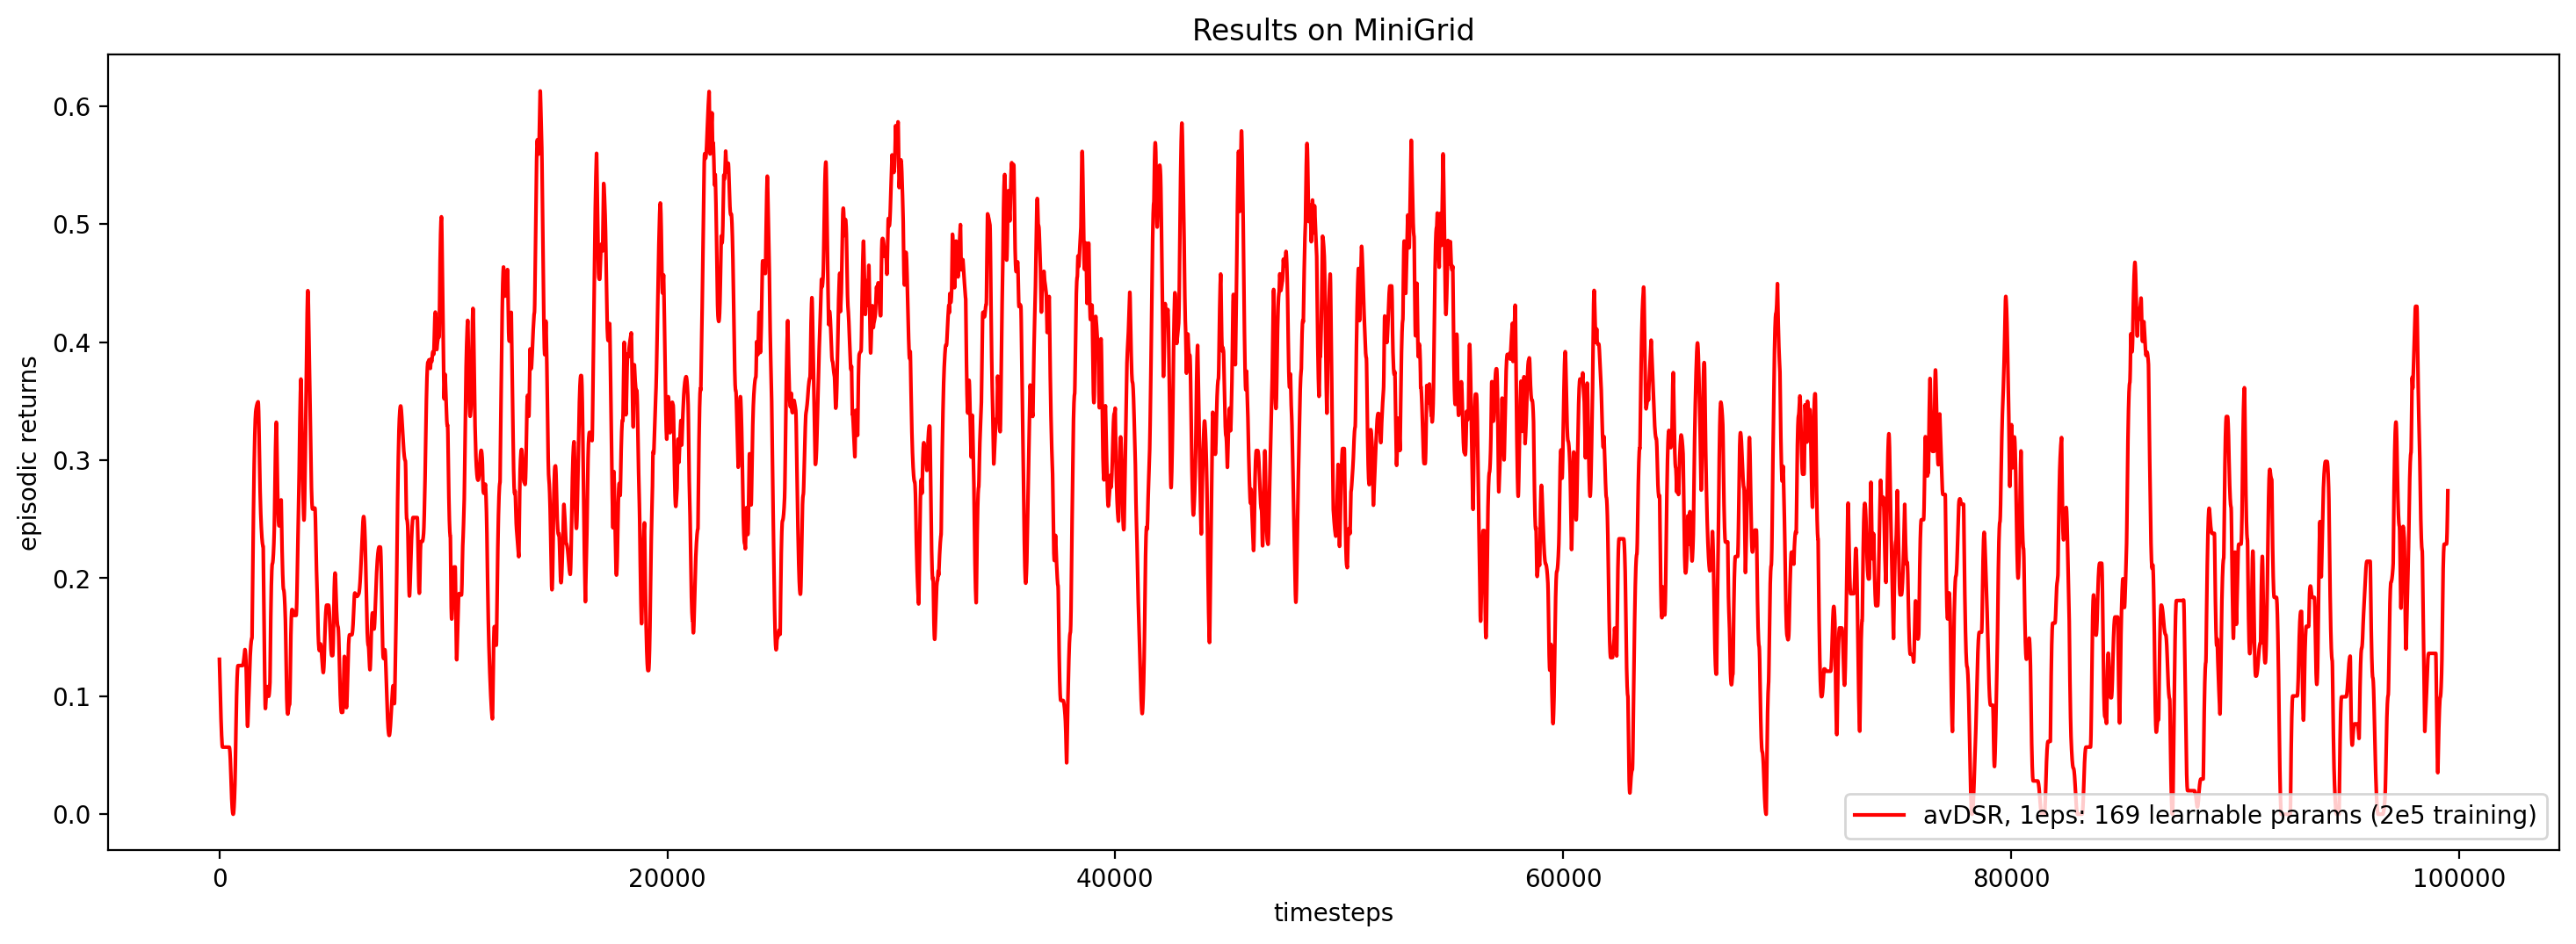

In [89]:
rewards_dict = {
#                 'DQN, h=(16,): 2788 learnable params': r_dqn_base_16[1:],
#                'DQN, h=(676,): 117628 learnable params': r_dqn_base_676[1:],
               'avDSR, 1eps: 169 learnable params (2e5 training)': r_c0[1:],
#                'avDSR, 1eps: 2708 learnable params (2e5 training)': r_c1[1:]
               }
# rewards_dict = {'avDSR, 1eps: 169 learnable params':r_dsr_rand,
#                 'avDSR, 1eps: 2708 learnable params':r_dsr_abs_rand[1:],
#                 'DQN, h=(676,): 117628 learnable params': r_dqn_base,
#                'DQN, h=(16,): 2788 learnable params': r_dqn_base2[1:]}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='Results on MiniGrid')

In [ ]:
import pickle
    
# with open('storage/rewards.pickle', 'wb') as f:
#     pickle.dump(rewards_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('storage/rewards.pickle', 'rb') as f:
    rewards = pickle.load(f)

r_dsr_rand = rewards['avDSR, 1eps: 169 learnable params']
r_dqn_base = rewards['DQN, h=(676,): 117628 learnable params']

### ROUGH BELOW

In [ ]:
"""
Adopted from https://github.com/alversafa/option-critic-arch/blob/master/fourrooms.py.

Modified to return one hot encoded states and gym compatible.

"""

import numpy as np
from gym.utils import seeding
from gym import spaces
import gym

class FourRoomsMatrix(gym.Env):

    def __init__(self, goal=62, p=0, config=2):
        """
        config -> configouration of the state space
            0 - returns tabular index of the state
            1 - returns one hot encoded vector of the state
            2 - returns matrix form of the state
        """
        layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        self.p = p # Stocasticity the environment
        self.config = config
        self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])
        
        # Four possible actions
        # 0: UP
        # 1: DOWN
        # 2: LEFT
        # 3: RIGHT
        self.a_space = np.array([0, 1, 2, 3])
        self.obs_space = np.zeros(np.sum(self.occupancy == 0))
        self.observation_space = spaces.Box(low=np.zeros(np.sum(self.occupancy == 0)), high=np.ones(np.sum(self.occupancy == 0)), dtype=np.uint8)
        self.action_space = spaces.Discrete(4)
        self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]

        # Random number generator
        self.rng = np.random.RandomState(1234)

        self.tostate = {}
        statenum = 0
        for i in range(13):
            for j in range(13):
                if self.occupancy[i,j] == 0:
                    self.tostate[(i,j)] = statenum
                    statenum += 1
        self.tocell = {v:k for k, v in self.tostate.items()}


        self.goal = goal # East doorway
        self.init_states = list(range(self.obs_space.shape[0]))
        self.init_states.remove(self.goal)
        self.updates = 0
        self.horizon = 200


    def render(self, show_goal=True):
        current_grid = np.array(self.occupancy)
        current_grid[self.current_cell[0], self.current_cell[1]] = -1
        if show_goal:
            goal_cell = self.tocell[self.goal]
            current_grid[goal_cell[0], goal_cell[1]] = -2
        return current_grid

    def seed(self, seed=None):
        """
        Setting the seed of the agent for replication
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        state = self.rng.choice(self.init_states)
        # state = 0 # fix starting state
        self.current_cell = self.tocell[state]
        if(self.config == 0):
            return state
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            self.updates = 0
            return temp
        elif(self.config == 2):
            return env.render()
        else:
            raise
            

    def check_available_cells(self, cell):
        available_cells = []

        for action in range(len(self.a_space)):
            next_cell = tuple(cell + self.directions[action])

            if not self.occupancy[next_cell]:
                available_cells.append(next_cell)

        return available_cells
        

    def step(self, action):
        '''
        Takes a step in the environment with 1-self.p probability. And takes a step in the
        other directions with probability self.p with all of them being equally likely.
        '''
        self.updates += 1

        next_cell = tuple(self.current_cell + self.directions[action])

        if not self.occupancy[next_cell]:

            if self.rng.uniform() < self.p:
                available_cells = self.check_available_cells(self.current_cell)
                self.current_cell = available_cells[self.rng.randint(len(available_cells))]

            else:
                self.current_cell = next_cell

        state = self.tostate[self.current_cell]

        # When goal is reached, it is done
        done = state == self.goal

        if(done):
            reward = 0
        else:
            reward = -1

        if(self.updates>=self.horizon):
            reward = -1
            done = True

        if(self.config == 0):
            return state, reward, done, {}
        elif(self.config == 1):
            temp = np.zeros(len(self.obs_space))
            temp[state] = 1
            return temp, reward, done, {}
        elif(self.config == 2):
            return env.render, reward, done, {}

        